In [7]:
import os
import gymnasium as gym
import numpy as np
import torch
from stable_baselines3 import DQN, A2C, PPO, SAC
from stable_baselines3.common.callbacks import BaseCallback
import crazy_driver_environment
import numpy
import matplotlib.pyplot as plt

class RewardTracker(BaseCallback):
    def __init__(self):
        super().__init__()
        self.episode_rewards = []
        self.current_ep_reward = 0

    def _on_step(self):
        # infos is a list of info dicts when using vectorized envs
        info = self.locals.get("infos", [{}])[0]
        reward = self.locals["rewards"][0]
        self.current_ep_reward += reward

        done = self.locals["dones"][0]
        if done:
            self.episode_rewards.append(self.current_ep_reward)
            self.current_ep_reward = 0
        return True



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

env = gym.make("CopChase-v0")
print(f"Created environment")

# First train PPO model for 1 million timesteps

# ppo_model = PPO("MlpPolicy", env, verbose=1)

ppo_model = PPO.load("../onem_ppo_model_finetuned", env)

# ppo_model.learn(total_timesteps=1_000_000)
# ppo_model.save("onem_ppo_model_finetuned")

sac_model = SAC("MlpPolicy", env, verbose=1)

obs, info = env.reset()

for i in range(100_000):

    if i % 1000 == 0:
        print(f"Warmup step {i}/100000")

    action, _ = ppo_model.predict(obs, deterministic=False)

    # Step with Gymnasium API
    next_obs, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

    # Add single transition to SAC replay buffer
    sac_model.replay_buffer.add(obs, next_obs, action, reward, done, [info])

    # Advance state
    if done:
        obs, info = env.reset()
    else:
        obs = next_obs

warm_cb = RewardTracker()
sac_model.learn(total_timesteps=100_000, callback=warm_cb)
sac_model.save("sac_highway_warm")
warm_rewards = np.array(warm_cb.episode_rewards)

# test training without warmup

sac_model2 = SAC("MlpPolicy", env, verbose=1)
obs = env.reset()


no_warm_cb = RewardTracker()
sac_model2.learn(total_timesteps=100_000, callback=no_warm_cb)
sac_model2.save("sac_highway_no_warm")
no_warm_rewards = np.array(no_warm_cb.episode_rewards)
print(f"Finished training")

Created environment
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Warmup step 0/100000
Warmup step 1000/100000
Warmup step 2000/100000
Warmup step 3000/100000
Warmup step 4000/100000
Warmup step 5000/100000
Warmup step 6000/100000
Warmup step 7000/100000
Warmup step 8000/100000
Warmup step 9000/100000
Warmup step 10000/100000
Warmup step 11000/100000
Warmup step 12000/100000
Warmup step 13000/100000
Warmup step 14000/100000
Warmup step 15000/100000
Warmup step 16000/100000
Warmup step 17000/100000
Warmup step 18000/100000
Warmup step 19000/100000
Warmup step 20000/100000
Warmup step 21000/100000
Warmup step 22000/100000
Warmup step 23000/100000
Warmup step 24000/100000
Warmup step 25000/100000
Warmup step 26000/100000
Warmup step 27000/100000
Warmup step 28000/100000
Warmup step 29000/100000
Warmup step 30000/100000
Warmup step 31000/100000
Warmup step 32000/1000

In [8]:
warm_rewards

array([-11524.04482061, -14851.13346076, -11654.17697057, ...,
           51.        ,     93.16409353,     16.49359268])

In [9]:
no_warm_rewards

array([-7.70812541e+03, -9.62760354e+03, -1.14537300e+04, ...,
       -1.50000000e+00, -1.60000000e+01,  6.50000000e+00])

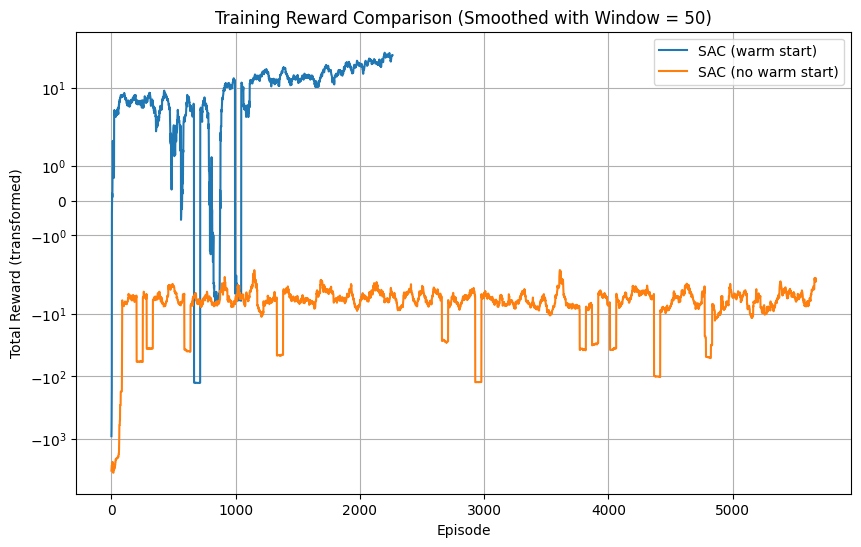

In [23]:
plt.figure(figsize=(10, 6))

# Create sliding window averages for smoother curves
window_size = 50

warm_rewards_copy = warm_rewards.copy()
no_warm_rewards_copy = no_warm_rewards.copy()

warm_rewards_copy = np.convolve(warm_rewards_copy, np.ones(window_size)/window_size, mode='valid')
no_warm_rewards_copy = np.convolve(no_warm_rewards_copy, np.ones(window_size)/window_size, mode='valid')

# # log transform to better visualize differences

# warm_rewards_copy = -1 * np.log(-1 * warm_rewards_copy + 1e-8)
# no_warm_rewards_copy = -1 * np.log(-1 * no_warm_rewards_copy + 1e-8)

plt.plot(warm_rewards_copy, label="SAC (warm start)")
plt.plot(no_warm_rewards_copy, label="SAC (no warm start)")
plt.xlabel("Episode")
plt.ylabel("Total Reward (transformed)")
plt.yscale("symlog")
plt.title("Training Reward Comparison (Smoothed with Window = 50)")
plt.legend()
plt.grid(True)
plt.show()

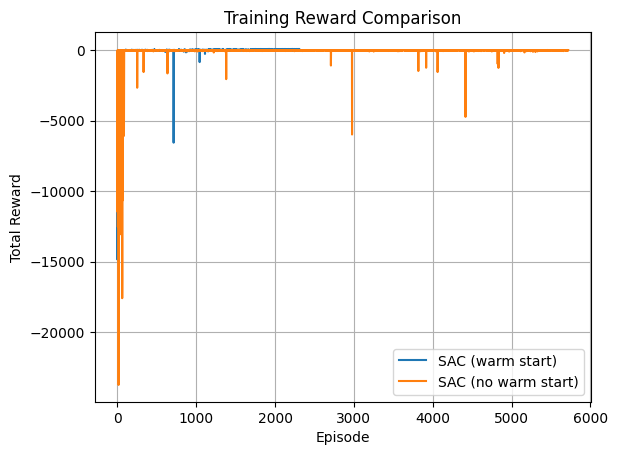

In [19]:
plt.plot(warm_rewards, label="SAC (warm start)")
plt.plot(no_warm_rewards, label="SAC (no warm start)")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Training Reward Comparison")
plt.legend()
plt.grid(True)
plt.show()

In [21]:
simple_base_model = PPO("MlpPolicy", env, verbose=1)

obs = env.reset()

simple_base_model.learn(total_timesteps=50_000)
simple_base_model.save("simple_base_ppo_50k")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 155       |
|    ep_rew_mean     | -8.35e+03 |
| time/              |           |
|    fps             | 102       |
|    iterations      | 1         |
|    time_elapsed    | 19        |
|    total_timesteps | 2048      |
----------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 135          |
|    ep_rew_mean          | -7.18e+03    |
| time/                   |              |
|    fps                  | 100          |
|    iterations           | 2            |
|    time_elapsed         | 40           |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0020660604 |
|    clip_fraction        | 0.00674      |
|    clip_range           | 0.2         